In [1]:
import math
import numpy as np
import scipy.special as spf
import vegas # numeric integration
import gvar # gaussian variables; for vegas
import time
import quaternionic # For rotations
# import spherical #For Wigner D matrix
# import csv # file IO for projectFnlm
# import os.path
import h5py # database format for mathcalI arrays
import importlib
import sys
import matplotlib.pyplot as plt
import matplotlib.colors as clr


sys.path.append('../')

import vsdm
from vsdm.units import *
from vsdm.utilities import *
vsdm.__version__

'0.1.0'

In [2]:
def projLM_r(wave, nlist, ell, m, r):
    # wave: ProjectFnlm object
    out = 0.0
    for n in nlist:
        nlm = (n, ell, m)
        fnlm = wave.f_nlm[nlm].mean
        Rnlm = wave.radRn(n, ell, r)
        out += fnlm*Rnlm
    return out 

"""Analytic result for comparison (radial function).

    f = sum_i c_i tg_i
"""

def g_i_lm(gvec, ell, m, u):
    # No factor of u0**3. g_i has units of 1/sigma**3. 
    (ci, vWsph_i, sigma_i) = gvec
    (ui, theta_i, phi_i) = vWsph_i
    cY_i = ci * vsdm.ylm_real(ell, m, theta_i, phi_i) / sigma_i**3
    factExp = math.exp(-(u-ui)**2/sigma_i**2)
    z = 2*u*ui/sigma_i**2
    if z==0:
        if ell==0:
            factIve = 4/math.sqrt(math.pi)
        else:
            factIve = 0
    else:
        factIve = math.sqrt(8/z) * spf.ive(ell+0.5, z)
    return cY_i * factExp * factIve

def gsum_lm(glist, ell, m, u):
    out = 0.0
    for gvec in glist:
        out += g_i_lm(gvec, ell, m, u)
    return out

def gaussian_stream_sum(ci, vWsph_i, sigma_i):
    # Arguments: lists of amplitudes gi, dispersions v0_i, and 
    #     lab-frame DM wind vectors vWsph_i, in spherical coordinates
    gvec_list = []
    for i in range(len(gi)):
        gaus = (ci[i], vWsph_i[i], sigma_i[i])
        gvec_list += [gaus]
    return gvec_list 

# Define a function to convert GaussianF(gX) into GaussianF(tilde_gX),
# for dimensionless function tilde_gX = u0**3 * gX,
# where u0 is the vsdm.Basis.u0 scale factor
def gX_to_tgX(gauF, u0):
    tgauF_vecs = gauF.rescaleGaussianF(u0**3)
    return vsdm.GaussianFnlm(gauF.basis, tgauF_vecs)


In [3]:
unisize = 3.5

In [4]:
plotpoints = 1025
sphw = vsdm.Basis(dict(u0=1, type='wavelet', uMax=1))
x = np.array([i/plotpoints for i in range(plotpoints+1)])
n1 = 1
n2 = 7
n3 = 10
n4 = 13
y1 = np.array([sphw.radRn(n1, 0, xi) for xi in x])
y2 = np.array([sphw.radRn(n2, 0, xi) for xi in x])
y3 = np.array([sphw.radRn(n3, 0, xi) for xi in x])
y4 = np.array([sphw.radRn(n4, 0, xi) for xi in x])
# print(y1)

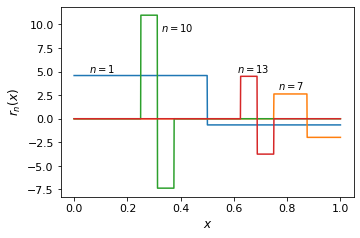

In [5]:
plt.figure(figsize=[1.5*unisize,unisize])
plt.plot(x, y1, x, y2, x, y3, x, y4)
plt.xlabel(r'$x$', fontsize=12)
plt.ylabel(r'$r_n(x)$', fontsize=12)
plt.xscale('linear')
plt.yscale('linear')
# plt.title(r'$H = \mathcal{H}/a$ vs proper time')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.figtext(0.2, 0.62, r'$n=1$')
plt.figtext(0.7, 0.55, r'$n=7$')
plt.figtext(0.39, 0.78, r'$n=10$')
plt.figtext(0.59, 0.62, r'$n=13$')
plt.show() 

## Function: Gaussian Sum

In [6]:
# Model 4: a bunch of streams, not symmetric. 
# Including the halo component without vEsc.
v0_main = 220*km_s
v0_a = 70*km_s
v0_b = 50*km_s
v0_c = 25*km_s
# vX_main = (230*km_s, np.pi, 0)
# vX_a = (113.13*km_s, 0.75*np.pi, 0) 
# vX_b = (315.28*km_s, 2.067, 4.265)
# vX_c = (1.5*256.71*km_s, 2.912, 0.540)
vX_main = vsdm.cart_to_sph((0, 0, -230*km_s))
vX_a = vsdm.cart_to_sph((80*km_s, 0, -80*km_s))
vX_b = vsdm.cart_to_sph((-120*km_s, -250*km_s, -150*km_s))
vX_c = vsdm.cart_to_sph((50*km_s, 30*km_s, -400*km_s))
sigma_i = [v0_main, v0_a, v0_b, v0_c]
vWsph_i = [vX_main, vX_a, vX_b, vX_c]
gi = [0.4, 0.3, 0.2, 0.1]
gvec_list_4 = gaussian_stream_sum(gi, vWsph_i, sigma_i)

VMAX = 960.*km_s # Global value for v0=vMax for wavelets
bdict = dict(u0=VMAX, type='wavelet', uMax=VMAX)
gXmodel_4 = vsdm.GaussianFnlm(bdict, gvec_list_4)
gtilde_4 = gX_to_tgX(gXmodel_4, VMAX)
gvec_tilde_4 = gtilde_4.gvec_list

In [7]:
print(np.array(vsdm.sph_to_cart(vX_main))/km_s)
print(np.array(vsdm.sph_to_cart(vX_a))/km_s)
print(np.array(vsdm.sph_to_cart(vX_b))/km_s)
print(np.array(vsdm.sph_to_cart(vX_c))/km_s)
print(gXmodel_4.distEnergyG()*VMAX**3)
print(gtilde_4.distEnergyG()/VMAX**3)

[ 2.81668764e-14  0.00000000e+00 -2.30000000e+02]
[ 80.   0. -80.]
[-120. -250. -150.]
[  50.   30. -400.]
2603594129.199007
2603594129.1990066


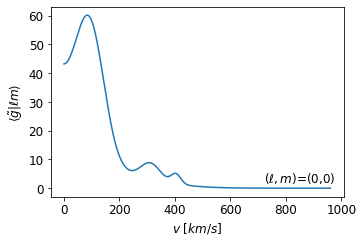

In [8]:
(ell, m) = (0, 0)
ur = np.array([xi*VMAX for xi in x])
g4_lm = np.array([gsum_lm(gvec_tilde_4, ell, m, u) for u in ur])


plt.figure(figsize=[1.5*unisize,unisize])
plt.plot(ur/km_s, g4_lm)
plt.xlabel(r'$v~[km/s]$', fontsize=12)
plt.ylabel(r'$ \langle\tilde{g}|\ell m\rangle$', fontsize=12)
plt.xscale('linear')
plt.yscale('linear')
# plt.title(r'$H = \mathcal{H}/a$ vs proper time')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
labeltext = r'$(\ell, m)$=' + '({},{})'.format(ell,m)  
plt.figtext(0.88, 0.17, labeltext, horizontalalignment='right',
            verticalalignment='bottom', fontsize=12)
plt.show() 

# Angular Convergence

In [9]:
tildeE = gtilde_4.distEnergyG()

In [10]:
ellMax = 120
ells = [l for l in range(ellMax+1)]

plotpoints = 401
x = np.linspace(0, 1, plotpoints)
ur = np.array([xi*VMAX for xi in x])

g4y = {}
# g4y_u2ell = {}
g4y2_u2 = {}
for ell in ells:
    for m in range(-ell, ell+1):
        lm = (ell, m)
        g4y[lm] = np.array([gsum_lm(gvec_tilde_4, ell, m, u) 
                            for u in ur])
#         g4y_u2ell[lm] = np.array([(ur[i]/VMAX)**2*g4y[lm][i] 
#                                   for i in range(len(ur))])
        g4y2_u2[lm] = np.array([(ur[i]/VMAX)**2*g4y[lm][i]**2 
                                  for i in range(len(ur))])



In [11]:
g4sum_l = {}
gv3 = gvec_list_4[3]
(ci, uSphi, sigmai) = gv3
(theta, phi) = (uSphi[1], uSphi[2])
g4sum_l[0] = ylm_real(0,0,theta,phi) * g4y[0,0]
for ell in ells[1:]:
    newterms = np.zeros_like(ur)
    for m in range(-ell, ell+1):
        lm = (ell, m)
        newterms += ylm_real(ell, m, theta, phi) * g4y[lm]
    g4sum_l[ell] = g4sum_l[ell-1] + newterms
g4sum_l['inf'] = np.array([gtilde_4.gU((u, theta, phi)) 
                           for u in ur])


In [12]:
ellBig = 60
for m in range(-ellBig, ellBig+1):
    lm = (ellBig, m)
    g4y[lm] = np.array([gsum_lm(gvec_tilde_4, ellBig, m, u) 
                        for u in ur])
#     g4y_u2ell[lm] = np.array([(ur[i]/VMAX)**2*g4y[lm][i] 
#                               for i in range(len(ur))])
    g4y2_u2[lm] = np.array([(ur[i]/VMAX)**2*g4y[lm][i]**2 
                              for i in range(len(ur))])



In [13]:
ellVeryBig = 90
for m in range(-ellVeryBig, ellVeryBig+1):
    lm = (ellVeryBig, m)
    g4y[lm] = np.array([gsum_lm(gvec_tilde_4, ellVeryBig, m, u) 
                        for u in ur])
#     g4y_u2ell[lm] = np.array([(ur[i]/VMAX)**2*g4y[lm][i] 
#                               for i in range(len(ur))])
    g4y2_u2[lm] = np.array([(ur[i]/VMAX)**2*g4y[lm][i]**2 
                              for i in range(len(ur))])


In [14]:
ellVeryVeryBig = 120
for m in range(-ellVeryVeryBig, ellVeryVeryBig+1):
    lm = (ellVeryVeryBig, m)
    g4y[lm] = np.array([gsum_lm(gvec_tilde_4, ellVeryVeryBig, m, u) 
                        for u in ur])
#     g4y_u2ell[lm] = np.array([(ur[i]/VMAX)**2*g4y[lm][i] 
#                               for i in range(len(ur))])
    g4y2_u2[lm] = np.array([(ur[i]/VMAX)**2*g4y[lm][i]**2 
                              for i in range(len(ur))])


In [15]:
g4y_l = {}
g4y2_u2_l = {}
for ell in ells+[ellBig,ellVeryBig,ellVeryVeryBig]:
    sum_m = 0.0
    sum2_m = 0.0
    for m in range(-ell, ell+1):
        lm = (ell,m)
        sum_m += g4y[lm]
        sum2_m += g4y2_u2[lm]
    g4y_l[ell] = sum_m
    g4y2_u2_l[ell] = sum2_m

## Angular Plots

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


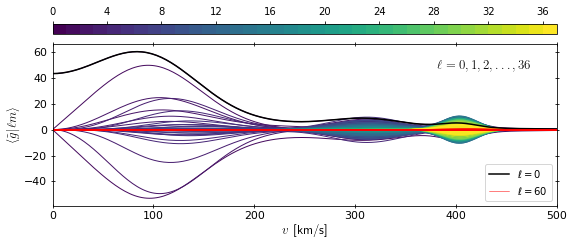

In [16]:
ellMin = 0
ellMax = 36
ells = [l for l in range(ellMin, ellMax+1)]

intervell = np.linspace(0, 1, len(ells))
colorell = [plt.cm.viridis(x) for x in intervell]

fig = plt.figure(figsize=[2.0*unisize,0.8*unisize])
"""Wavelet: Function values"""
xtix = [0,100,200,300,400,500,600,700,800,900,960]
ax = fig.add_axes([0,0,1,1], xscale='linear', yscale='linear')
# ax.set_xticks(xtix)
ax.set_xlabel(r'$v$ [km/s]', fontsize=13, usetex=True)
ax.set_ylabel(r'$\langle\tilde{g}|\ell m\rangle$', 
              fontsize=13, usetex=True)
for i,ell in enumerate(ells):
    for m in range(-ell, ell+1):
        ax.plot(ur/km_s, g4y[(ell,m)], color=colorell[i],
                linewidth=1)

ax.plot(ur/km_s, g4y[(0,0)], color='black', label=r'$\ell=0$')
for m in range(-ellBig, ellBig+1):
    if m==0:        
        ax.plot(ur/km_s, g4y[(ellBig,m)], color='red', 
                label=r'$\ell={}$'.format(ellBig), linewidth=0.5)
    else:        
        ax.plot(ur/km_s, g4y[(ellBig,m)], color='red', 
                linewidth=1)
    
ax.tick_params(axis='both', labelsize=11, direction='inout',
               right=True, top=True)

labeltext = r'$\ell = 0, 1, 2, \ldots, {}$'.format(ellMax)  
ax.text(0.95, 0.9, labeltext, horizontalalignment='right',
        verticalalignment='top', fontsize=13, 
        transform=ax.transAxes, usetex=True)
# labeltext2 = r'($\ell = 60$)'  
# ax.text(0.95, 0.45, labeltext2, horizontalalignment='right',
#         verticalalignment='top', fontsize=13, 
#         transform=ax.transAxes, usetex=True)
ax.set_xlim([0,500])
ax.legend(loc='lower right')


cnorm = plt.Normalize(vmin=ellMin, vmax=ellMax)
boundaries = np.array(ells)
boundaries = np.append(boundaries, boundaries[-1] + 1)
clmap = plt.cm.ScalarMappable(norm=cnorm, cmap='viridis')

fig.colorbar(mappable=clmap,  
             boundaries=boundaries, values=ells,
             orientation='horizontal', location='top', 
             aspect=50)
fig.show() 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:87: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


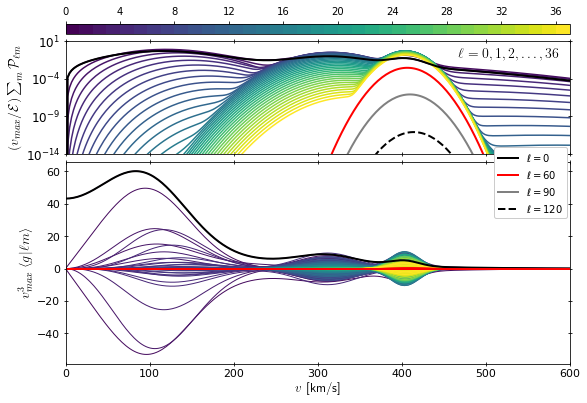

In [17]:
fig = plt.figure(figsize=[2.0*unisize,0.8*unisize])

vlim = [0,600]
"""Wavelet: Function values"""
xtix = [0,100,200,300,400,500,600,700,800,900,960]
ax1 = fig.add_axes([0,0,1,1], xscale='linear', yscale='linear')
# ax.set_xticks(xtix)
ax1.set_xlabel(r'$v$ [km/s]', fontsize=13, usetex=True)
ax1.set_ylabel(r'$v_{max}^3\ \langle g|\ell m\rangle$', 
               fontsize=14, usetex=True)
for i,ell in enumerate(ells):
    for m in range(-ell, ell+1):
        ax1.plot(ur/km_s, g4y[(ell,m)], color=colorell[i], 
                 linewidth=1)

ax1.plot(ur/km_s, g4y[(0,0)], color='black', label=r'$\ell=0$',
         linewidth=2)
for m in range(-ellBig, ellBig+1):
    if m==0:        
        ax1.plot(ur/km_s, g4y[(ellBig,m)], color='red', 
                label=r'$\ell={}$'.format(ellBig), linewidth=1)
    else:        
        ax1.plot(ur/km_s, g4y[(ellBig,m)], color='red', 
                 linewidth=1)
    
ax1.tick_params(axis='both', labelsize=11, direction='inout',
                right=True, top=True,  
                labelbottom=True, labeltop=False)

labeltext = r'$\ell = 0, 1, 2, \ldots, 36$'  
# ax1.text(0.95, 0.95, labeltext, horizontalalignment='right',
#          verticalalignment='top', fontsize=13, 
#          transform=ax1.transAxes, usetex=True)
# labeltext2 = r'($\ell = 60$)'  
# ax.text(0.95, 0.45, labeltext2, horizontalalignment='right',
#         verticalalignment='top', fontsize=13, 
#         transform=ax.transAxes, usetex=True)
ax1.set_xlim(vlim)
# ax1.legend(loc='lower right')

ax_Pl = fig.add_axes([0,1.04,1,0.7], xscale='linear', yscale='log')
# ax.set_xticks(xtix)
# ax_Pl.set_xlabel(r'$v$ [km/s]', fontsize=13, usetex=True)
ax_Pl.set_ylabel(r'$(v_{max}/\mathcal E) \sum_m  \mathcal P_{\ell m}$', 
              fontsize=14, usetex=True)
for i,ell in enumerate(ells):
    ax_Pl.plot(ur/km_s, g4y2_u2_l[ell]/tildeE, 
               color=colorell[i])

ax_Pl.plot(ur/km_s, g4y2_u2_l[0]/tildeE, 
           color='black', label=r'$\ell=0$',
           linewidth=2)
ax_Pl.plot(ur/km_s, g4y2_u2_l[ellBig]/tildeE, 
           color='red', 
           label=r'$\ell={}$'.format(ellBig), linewidth=2)
ax_Pl.plot(ur/km_s, 
           g4y2_u2_l[ellVeryBig]/tildeE, 
           color='gray', 
           label=r'$\ell={}$'.format(ellVeryBig), linewidth=2)
ax_Pl.plot(ur/km_s, g4y2_u2_l[ellVeryVeryBig]/tildeE, 
           color='black', linestyle='dashed',
           label=r'$\ell={}$'.format(ellVeryVeryBig), linewidth=2)
    
ax_Pl.tick_params(axis='both', labelsize=12, direction='inout',
                  right=True, top=True, 
                  labelbottom=False, labeltop=False)

labeltext = r'$\ell = 0, 1, 2, \ldots, {}$'.format(ellMax)  
ax_Pl.text(0.98, 0.94, labeltext, horizontalalignment='right',
           verticalalignment='top', fontsize=14, 
           transform=ax_Pl.transAxes, usetex=True)
ax_Pl.set_xlim(vlim)
ax_Pl.set_ylim([1e-14,10])
# ax_Pl.set_yticks([1e-12,1e-9,1e-6,1e-3,1])
ax_Pl.legend(loc=[0.85,-0.57], framealpha=1)


cnorm = plt.Normalize(vmin=ellMin, vmax=ellMax)
boundaries = np.array(ells)
boundaries = np.append(boundaries, boundaries[-1] + 1)
clmap = plt.cm.ScalarMappable(norm=cnorm, cmap='viridis')

fig.colorbar(mappable=clmap,  
             boundaries=boundaries, values=ells,
             orientation='horizontal', location='top', 
             aspect=50)
fig.show() 




/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


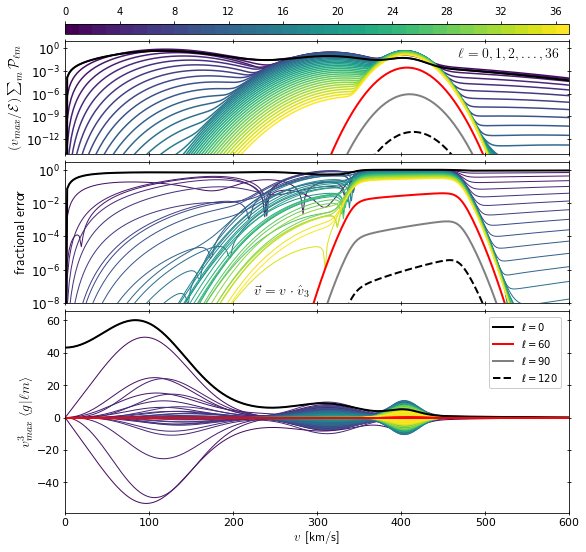

In [18]:
ellMin = 0
ellMax = 36
ells = [l for l in range(ellMin, ellMax+1)]

intervell = np.linspace(0, 1, len(ells))
colorell = [plt.cm.viridis(x) for x in intervell]

fig = plt.figure(figsize=[2.0*unisize,0.8*unisize])

vlim = [0,600]
"""Wavelet: Function values"""
xtix = [0,100,200,300,400,500,600,700,800,900,960]
ax1 = fig.add_axes([0,0,1,1], xscale='linear', yscale='linear')
# ax.set_xticks(xtix)
ax1.set_xlabel(r'$v$ [km/s]', fontsize=13, usetex=True)
ax1.set_ylabel(r'$v_{max}^3\ \langle g|\ell m\rangle$', 
               fontsize=14, usetex=True)
for i,ell in enumerate(ells):
    for m in range(-ell, ell+1):
        ax1.plot(ur/km_s, g4y[(ell,m)], color=colorell[i], 
                 linewidth=1)

ax1.plot(ur/km_s, g4y[(0,0)], color='black', label=r'$\ell=0$',
         linewidth=2)
for m in range(-ellBig, ellBig+1):
    if m==0:        
        ax1.plot(ur/km_s, g4y[(ellBig,m)], color='red', 
                label=r'$\ell={}$'.format(ellBig), linewidth=1)
    else:        
        ax1.plot(ur/km_s, g4y[(ellBig,m)], color='red', 
                 linewidth=1)
    
ax1.tick_params(axis='both', labelsize=11, direction='inout',
                right=True, top=True,  
                labelbottom=True, labeltop=False)

labeltext = r'$\ell = 0, 1, 2, \ldots, 36$'  
# ax1.text(0.95, 0.95, labeltext, horizontalalignment='right',
#          verticalalignment='top', fontsize=13, 
#          transform=ax1.transAxes, usetex=True)
# labeltext2 = r'($\ell = 60$)'  
# ax.text(0.95, 0.45, labeltext2, horizontalalignment='right',
#         verticalalignment='top', fontsize=13, 
#         transform=ax.transAxes, usetex=True)
ax1.set_xlim(vlim)
# ax1.legend(loc='lower right')


ax_rel = fig.add_axes([0,1.04,1,0.7], xscale='linear', yscale='log')
# ax_rel.set_xticks(xtix)
# ax_rel.set_xlabel(r'$v$ [km/s]', fontsize=13, usetex=True)
ax_rel.set_ylabel('fractional error', 
                  fontsize=14, usetex=True)
for i,ell in enumerate(ells):
    ax_rel.plot(ur/km_s, 
                np.abs(g4sum_l['inf']-g4sum_l[ell])/g4sum_l['inf'], 
                color=colorell[i],
                linewidth=1)
ax_rel.plot(ur/km_s, 
           np.abs(g4sum_l['inf']-g4sum_l[0])/g4sum_l['inf'], 
           color='black', label=r'$\ell=0$',
           linewidth=2)
ax_rel.plot(ur/km_s, 
           np.abs(g4sum_l['inf']-g4sum_l[ellBig])/g4sum_l['inf'], 
           color='red', 
           label=r'$\ell={}$'.format(ellBig), linewidth=2)
ax_rel.plot(ur/km_s, 
           np.abs(g4sum_l['inf']-g4sum_l[ellVeryBig])/g4sum_l['inf'], 
           color='gray', 
           label=r'$\ell={}$'.format(ellVeryBig), linewidth=2)
ax_rel.plot(ur/km_s, 
           np.abs(g4sum_l['inf']-g4sum_l[ellVeryVeryBig])/g4sum_l['inf'], 
           color='black', linestyle='dashed',
           label=r'$\ell={}$'.format(ellVeryVeryBig), linewidth=2)

ax_rel.tick_params(axis='both', labelsize=12, direction='inout',
                  right=True, top=True, 
                  labelbottom=False, labeltop=False)

labeltext = r'$\vec v = v \cdot \hat{v}_3$'  
ax_rel.text(0.43, 0.04, labeltext, horizontalalignment='center',
            verticalalignment='bottom', fontsize=14, 
            transform=ax_rel.transAxes, usetex=True)
ax_rel.set_xlim(vlim)
ax_rel.set_ylim([1e-8, 3])
ax_rel.legend(loc=[0.84,-0.6], framealpha=1)



ax_Pl = fig.add_axes([0,1.78,1,0.7], xscale='linear', yscale='log')
# ax.set_xticks(xtix)
# ax_Pl.set_xlabel(r'$v$ [km/s]', fontsize=13, usetex=True)
ax_Pl.set_ylabel(r'$(v_{max}/\mathcal E) \sum_m  \mathcal P_{\ell m}$', 
              fontsize=14, usetex=True)
for i,ell in enumerate(ells):
    ax_Pl.plot(ur/km_s, g4y2_u2_l[ell]/tildeE, 
               color=colorell[i])

ax_Pl.plot(ur/km_s, g4y2_u2_l[0]/tildeE, 
           color='black', label=r'$\ell=0$',
           linewidth=2)
ax_Pl.plot(ur/km_s, g4y2_u2_l[ellBig]/tildeE, 
           color='red', 
           label=r'$\ell={}$'.format(ellBig), linewidth=2)
ax_Pl.plot(ur/km_s, 
           g4y2_u2_l[ellVeryBig]/tildeE, 
           color='gray', 
           label=r'$\ell={}$'.format(ellVeryBig), linewidth=2)
ax_Pl.plot(ur/km_s, g4y2_u2_l[ellVeryVeryBig]/tildeE, 
           color='black', linestyle='dashed',
           label=r'$\ell={}$'.format(ellVeryVeryBig), linewidth=2)
    
ax_Pl.tick_params(axis='both', labelsize=12, direction='inout',
                  right=True, top=True, 
                  labelbottom=False, labeltop=False)

labeltext = r'$\ell = 0, 1, 2, \ldots, {}$'.format(ellMax)  
ax_Pl.text(0.98, 0.94, labeltext, horizontalalignment='right',
           verticalalignment='top', fontsize=14, 
           transform=ax_Pl.transAxes, usetex=True)
ax_Pl.set_xlim(vlim)
ax_Pl.set_ylim([1e-14,10])
ax_Pl.set_yticks([1e-12,1e-9,1e-6,1e-3,1])
# ax_Pl.legend(loc=[0.85,-0.57], framealpha=1)


cnorm = plt.Normalize(vmin=ellMin, vmax=ellMax)
boundaries = np.array(ells)
boundaries = np.append(boundaries, boundaries[-1] + 1)
clmap = plt.cm.ScalarMappable(norm=cnorm, cmap='viridis')

fig.colorbar(mappable=clmap,  
             boundaries=boundaries, values=ells,
             orientation='horizontal', location='top', 
             aspect=50)
fig.show() 




## Including numeric results

In [21]:
csvname = 'gX_model4'

gvegas_params = dict(neval=1e5, nitn=7, nitn_init=3, 
                     neval_init=1e3, verbose=True)

"""Read from hdf5..."""
t0 = time.time()
wave_csv = vsdm.ProjectFnlm(bdict, gtilde_4, gvegas_params, 
                            nlmlist=None, f_type='gX')
wave_csv.importFnlm_csv('demo/'+csvname+'.csv')
print('nCoeffs = {}'.format(len(wave_csv.getNLMlist())))
# print('is_gaussian: ', wave4.is_gaussian)
print('read time: {}'.format(time.time()-t0))
totalAllEnergy = wave_csv.distEnergyG()
print(totalAllEnergy)


nCoeffs = 262848
read time: 5.528627872467041
85.49227309085924


In [22]:
"""Direct calculation of norm"""
vegas_energy = dict(neval=1e6, nitn=10, verbose=True,  
                    nitn_init=5, neval_init=3e3)
totalEnergy = wave_csv.getDistEnergy(vegas_energy, integrateG=True)
print(totalEnergy)


itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   72.67(16)       72.67(16)           0.00     1.00
  2   72.484(70)      72.513(64)          1.10     0.29
  3   72.449(54)      72.476(41)          0.85     0.43
  4   72.351(45)      72.419(30)          1.95     0.12
  5   72.315(30)      72.366(21)          2.95     0.02
  6   72.346(25)      72.357(16)          2.44     0.03
  7   72.362(23)      72.359(13)          2.04     0.06
  8   72.354(18)      72.357(11)          1.75     0.09
  9   72.347(18)      72.3545(91)         1.56     0.13
 10   72.358(16)      72.3553(79)         1.39     0.18

energy: 72.3553(79)
72.3553(79)


In [24]:
totalEnergy = totalEnergy.mean
min_frac_power = 0
min_power = min_frac_power*totalEnergy
min_fnlm = math.sqrt(min_power)

t0 = time.time()
principal_fnlm = {}
for nlm,fnlm in wave_csv.f_nlm.items():
    if math.fabs(fnlm.mean) > min_fnlm:
        principal_fnlm[nlm] = fnlm.mean 
tEval = time.time()-t0
print('filter time:', tEval)
print('nCoeffs:', len(principal_fnlm))

filter time: 0.10710811614990234
nCoeffs: 262848


In [25]:
energy = wave_csv.f2nlm_energy()
print(energy/totalEnergy)

0.9625898(59)


In [29]:
powerL = wave_csv.getLpower()
# print(powerL.values())
sum_l = 0.
conv_l = []
for key,power in powerL.items():
    power /= totalEnergy
    sum_l += power
    conv_l += [sum_l.mean]
    print('{}  \t{:.6G}  \t{:.6G}'.format(key, power.mean, sum_l.mean))


1  	0.106423  	0.106423
2  	0.0766082  	0.183032
0  	0.0682675  	0.251299
3  	0.0501789  	0.301478
4  	0.039296  	0.340774
5  	0.0368144  	0.377588
6  	0.0364322  	0.414021
7  	0.0356484  	0.449669
8  	0.0346141  	0.484283
9  	0.0338464  	0.518129
10  	0.0328941  	0.551024
11  	0.0310323  	0.582056
12  	0.0284501  	0.610506
13  	0.0261056  	0.636612
14  	0.0245555  	0.661167
15  	0.0234757  	0.684643
16  	0.0222881  	0.706931
17  	0.0209015  	0.727832
18  	0.019659  	0.747491
19  	0.0187806  	0.766272
20  	0.0181053  	0.784377
21  	0.0173784  	0.801756
22  	0.0165036  	0.818259
23  	0.0156087  	0.833868
24  	0.0147772  	0.848645
25  	0.0139841  	0.862629
26  	0.0131652  	0.875795
27  	0.0123033  	0.888098
28  	0.0114265  	0.899524
29  	0.0105794  	0.910104
30  	0.00975725  	0.919861
31  	0.00895696  	0.928818
32  	0.00817662  	0.936995
33  	0.00742371  	0.944418
34  	0.00671247  	0.951131
35  	0.0060433  	0.957174
36  	0.00541579  	0.96259
